### Imports

In [1]:
import pandas as pd
import os
from tqdm import tqdm

### Check if edges are valid (i.e. they are from and to existing nodes)

In [2]:
# input folder
input_folder = "../data/my_datasets/"

In [3]:
def check_edges(dataset, id_str, ori_str, dest_str):
    # load nodes
    print("Loading nodes...")
    nodes = pd.read_csv(input_folder+dataset+"_nodes.csv", sep=';', dtype=pd.StringDtype())
    # create set of ids of the nodes
    #nodes_ids = nodes[[id_str]]
    ids_set = set(nodes[id_str].unique())#without header
    #print(ids_set)
    print("Loading edges...")
    # load edges
    edges = pd.read_csv(input_folder+dataset+"_edges.csv", sep=';', dtype=pd.StringDtype())
    edges_ids = edges[[ori_str, dest_str]]
    invalid_edges = []
    with tqdm(total=len(list(edges_ids.iterrows()))) as pbar:
        for index, edg in edges_ids.iterrows():
            pbar.update(1)
            if edg[ori_str] not in ids_set:
                invalid_edges.append(edg[ori_str])
            if edg[dest_str] not in ids_set:
                invalid_edges.append(edg[dest_str])
    print("Invalid edges for {}: {}".format(dataset, invalid_edges))
    return invalid_edges
        
##The invalid edge in AUI is (190647, 52155)

In [4]:
tmp = check_edges("AUI", "NDG", "NDG_ORIGINE", "NDG_DESTINAZIONE")
tmp = check_edges("CTP", "CD_NDG", "ID_NODO_ORIGINE", "ID_NODO_DESTINAZIONE")
tmp = check_edges("NEXI", "ID_NODO", "ID_NODO_ORIGINE", "ID_NODO_DESTINAZIONE")

100%|██████████| 1281116/1281116 [01:52<00:00, 11401.39it/s]


Invalid edges for AUI: ['0000000000190647']


100%|██████████| 1674271/1674271 [02:27<00:00, 11332.50it/s]


Invalid edges for CTP: []


100%|██████████| 1524509/1524509 [02:13<00:00, 11387.82it/s]


Invalid edges for NEXI: []


### Check which datasets are multigraphs

In [ ]:
# set input folder
input_folder = "../data/my_datasets/"

In [2]:
def is_multigraph(dataset, ori_str, dest_str):
    # load edges in ram
    edges = pd.read_csv(input_folder+dataset+"_edges.csv", sep=';', dtype=pd.StringDtype())
    # keep only columns containing origin and destination ids
    only_ids = edges[[ori_str, dest_str]]
    num_edges = len(only_ids)
    unique_edges = only_ids.drop_duplicates()
    num_unique_edges = len(unique_edges)
    if num_unique_edges < num_edges:
        print("{}: total number {} vs unique edges {}".format(dataset, num_edges, num_unique_edges))
        return True
    else:
        return False

In [3]:
tmp = is_multigraph("AUI", "NDG_ORIGINE", "NDG_DESTINAZIONE")
tmp = is_multigraph("CTP", "ID_NODO_ORIGINE", "ID_NODO_DESTINAZIONE")
tmp = is_multigraph("NEXI", "ID_NODO_ORIGINE", "ID_NODO_DESTINAZIONE")

AUI: total number 1281116 vs unique edges 247321
CTP: total number 1674271 vs unique edges 1519361
NEXI: total number 1524509 vs unique edges 873433


True

### Check sign of field "importo"

In [26]:
def check_negative_values(edges, field):
    num_edges = edges.shape[0]
    print("Total number of edges: {}".format(num_edges))
    negative_values = []
    for importo in edges[field]:
        if importo < 0:
            negative_values.append(importo)
    print("Number of negative values for {}: {}".format(field, len(negative_values)))

In [27]:
input_folder = "../data/my_datasets/"
dataset = "AUI"
AUI_edges = pd.read_csv(input_folder+dataset+"_edges.csv", sep=';', low_memory=False)
dataset = "NEXI"
NEXI_edges = pd.read_csv(input_folder+dataset+"_edges.csv", sep=';', low_memory=False)

**AUI**

In [28]:
check_negative_values(AUI_edges, "IMPORTO")
check_negative_values(AUI_edges, "IMPORTO_CONTANTE")

Total number of edges: 1281116
Number of negative values for IMPORTO: 0
Total number of edges: 1281116
Number of negative values for IMPORTO_CONTANTE: 0


**NEXI**

In [29]:
check_negative_values(NEXI_edges, "IMPORTO")

Total number of edges: 1524509
Number of negative values for IMPORTO: 0


### More on AUI edges

In [35]:
AUI_rap = AUI_edges.loc[AUI_edges['TIPO_OPERAZIONE'] == 'RAP']
print("Number of edges: {}".format(len(AUI_edges)))
AUI_mov = AUI_edges.loc[AUI_edges['TIPO_OPERAZIONE'] == 'MOV']
print("Number of edges with valid fields: {}".format(len(AUI_mov) + len(AUI_rap)))
#OBS: there is an edge with no values in any column
AUI_edges.loc[AUI_edges['TIPO_OPERAZIONE'] == '0']

Number of edges: 1281116
Number of edges with valid fields: 1281115


,NDG_ORIGINE,NDG_DESTINAZIONE,TIPO_OPERAZIONE,RAPPORTO,TIPO_LEGAME,DATA_OPERAZIONE,CAUSALE_ANALITICA,SEGNO,IMPORTO,IMPORTO_CONTANTE
801892,0000000001432584,0000000001432584,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create subgraphs for faster tests

In [4]:
# set input and output folders
input_folder ="../data/my_datasets/"
output_folder="../data/my_datasets/small/"

In [11]:
def make_subgraph(dataset, id_name, id_ori_name, id_dest_name, num_lines):
    print("Creating "+ dataset + " subgraph of {} nodes".format(num_lines))
    #Load nodes
    nodes = pd.read_csv(input_folder+dataset+"_nodes.csv", sep=';', dtype=pd.StringDtype())
    #Sort descending
    #sorted_nodes = nodes.sort_values(by=id_name, ascending=False)
    #Store the first num_lines rows in new csv
    nodes.head(num_lines).to_csv(output_folder+dataset+"_nodes.csv", sep=';', index=False)
    #Creating list of UNIQUE NDGS of the first num_lines rows
    nodes_ids = nodes.head(num_lines)[id_name].tolist()

    #Load edges
    edges = pd.read_csv(input_folder+dataset+"_edges.csv", sep=';', dtype=pd.StringDtype())
    #Select rows from existing nodes
    from_existing = edges[edges[id_ori_name].isin(nodes_ids)]
    #Filter those and take only the edges to existing nodes
    to_existing = from_existing[from_existing[id_dest_name].isin(nodes_ids)]
    #Store the edges
    edg_name = output_folder+dataset+"_edges.csv"
    to_existing.to_csv(edg_name, sep=';', index=False)
    #os.system("wc -l "+ edg_name + " | cut -f1 -d' '")

In [12]:
# Delete all files from output folder
os.system("rm "+output_folder+"*.csv")
# Create AUI subgraph of n_nodes nodes
n_nodes = 200
make_subgraph("AUI", "NDG", "NDG_ORIGINE", "NDG_DESTINAZIONE", n_nodes)
# Create CTP subgraph of n_nodes nodes
n_nodes = 500
make_subgraph("CTP", "CD_NDG", "ID_NODO_ORIGINE", "ID_NODO_DESTINAZIONE", n_nodes)
# Create NEXI subgraph of n_nodes nodes
n_nodes = 40000
make_subgraph("NEXI", "ID_NODO", "ID_NODO_ORIGINE", "ID_NODO_DESTINAZIONE", n_nodes)

Creating AUI subgraph of 200 nodes
Creating CTP subgraph of 500 nodes
Creating NEXI subgraph of 40000 nodes


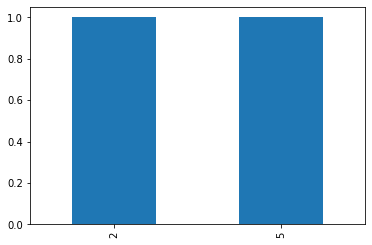

In [42]:
import matplotlib.pyplot as plt
data = pd.read_csv("scc_sizes.csv", sep=',', dtype=pd.StringDtype())

fig, ax = plt.subplots()
data['Size'].value_counts().plot(ax=ax, kind='bar')
